In [82]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time
from sklearn import metrics
import seaborn as sns   
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score

In [69]:
df = pd.read_csv('filtered_energydata.csv')

In [70]:
X = df.drop(['Appliances'], axis=1)
y = df['Appliances']
Scaler = StandardScaler()
X = Scaler.fit_transform(X)

In [71]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [72]:
# I got this idea from Kaggle that someone did this to find the best model for their dataset.
models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['SVR:' , SVR()],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingClassifier: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()] ,
           ['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]

In [76]:
# I need a list to save result for each model
model_data = []
for name, curr_model in models:
    # I use random state to ensure that randomness in models is controlled
    curr_model.random_state = 78
    start = time.time()
    curr_model.fit(x_train, y_train)
    end = time.time()
    curr_model_data = {
        "Name": name,
        "Train_Time": end - start,
        "Train_R2_Score": metrics.r2_score(y_train, curr_model.predict(x_train)),
        "Test_R2_Score": metrics.r2_score(y_test, curr_model.predict(x_test)),
        "Test_RMSE_Score": f"{sqrt(mean_squared_error(y_test, curr_model.predict(x_test))):.2f} Wh"
    }
    model_data.append(curr_model_data)

In [77]:
model_data = pd.DataFrame(model_data)  
model_data 

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,Lasso:,0.779799,0.167939,0.174499,39.32 Wh
1,Ridge:,0.001975,0.186000,0.197045,38.78 Wh
2,KNeighborsRegressor:,0.012043,0.790857,0.668432,24.92 Wh
3,SVR:,5.594276,0.219834,0.221585,38.18 Wh
4,RandomForest,9.018900,0.960768,0.723378,22.76 Wh
5,ExtraTreeRegressor :,2.827211,1.000000,0.741671,22.00 Wh
6,GradientBoostingClassifier:,2.060143,0.481580,0.441909,32.33 Wh
7,XGBRegressor:,0.106506,0.855061,0.669011,24.90 Wh
8,MLPRegressor:,6.265632,0.558741,0.508558,30.34 Wh


In [56]:
param_grid = [{
              'max_depth': [80, 150, 200,250],
              'n_estimators' : [100,150,200,250],
              'max_features': [1.0, "sqrt", "log2"]
            }]
reg = ExtraTreesRegressor(random_state=40)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 5, n_jobs = -1 , scoring='r2' , verbose=2)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=40), n_jobs=-1,
             param_grid=[{'max_depth': [80, 150, 200, 250],
                          'max_features': [1.0, 'sqrt', 'log2'],
                          'n_estimators': [100, 150, 200, 250]}],
             scoring='r2', verbose=2)

In [57]:
grid_search.best_params_

{'max_depth': 80, 'max_features': 'sqrt', 'n_estimators': 250}

In [58]:
grid_search.best_estimator_

ExtraTreesRegressor(max_depth=80, max_features='sqrt', n_estimators=250,
                    random_state=40)

In [59]:
grid_search.best_estimator_.score(x_train, y_train)

0.9999992968498146

In [62]:
grid_search.best_estimator_.score(x_test,y_test)

0.7565706261441856

In [78]:
prediction = grid_search.best_estimator_.predict(x_test)

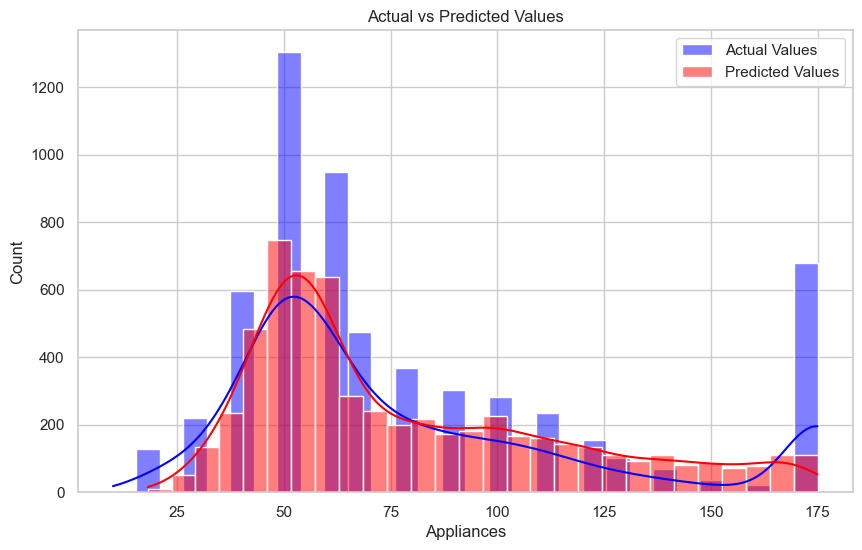

In [79]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual Values')
sns.histplot(prediction, kde=True, color='red', label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [85]:
# Evaluating the model
mae_value = mae(y_test, prediction)
mse_value = mse(y_test, prediction)
rmse_value = np.sqrt(mse_value)
r2_value = r2_score(y_test, prediction)

print(f"Mean Absolute Error (MAE): {mae_value:.2f} Wh")
print(f"Mean Squared Error (MSE): {mse_value:.2f} Wh²")
print(f"Root Mean Squared Error (RMSE): {rmse_value:.2f} Wh")
print(f"R² Score: {r2_value:.2f}")

Mean Absolute Error (MAE): 13.76 Wh
Mean Squared Error (MSE): 455.98 Wh²
Root Mean Squared Error (RMSE): 21.35 Wh
R² Score: 0.76


## <span style="color: #20C997;">Personal Analysis</span>
ExtraTreesRegressor is the best model for this dataset because, it has smallest errors than others models. It can capture data patterns much better than others.<br>
It explains most variation. But there is a problem for training data, score is almost 1, which means model is overfitted, visualization shows the overfitting.    
